# Superstepping

The idea behind superstepping is to view a regular timestep update as a matrix operation that acts on the field at the previous two timesteps:
$$
\begin{pmatrix}
u^{n+1}\\u^n
\end{pmatrix}
=
A
\begin{pmatrix}
u^n\\u^{n-1}
\end{pmatrix}
$$
Superstepping then uses the repeated action of this operation to construct the timestep $u^{n + k}$ from $u^n$ and $u^{n - 1}$. Conceptually this can be thought of as taking the matrix power:
$$
\begin{pmatrix}
u^{n+k}\\u^{n+k-1}
\end{pmatrix}
=
A^k
\begin{pmatrix}
u^n\\u^{n-1}
\end{pmatrix}
$$
This notebook demonstrates the use of a proof of concept superstep stencil available in Devito.

We will recreate the example in Nemeth et al. [[1]](#References) performing an acoustic propagation with zero Dirichlet boundary conditions, ie: reflective boundaries and perform source injection.

## Constant background velocity
First we start by reproducing a simulation similar to Figure 5 in Nemeth et al.[[1]](#References), with uniform constant background velocity and then reproduce figures 6 and 7 using a subset of the Marmousi background velocity.

Start by importing all of the tools we will need; note that the superstepping functionality is imported from the `devito.timestepping.superstep` module:

In [1]:
from sympy import pprint
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter

from devito import Grid, Function, TimeFunction, VectorTimeFunction, Eq, solve, Operator, ConditionalDimension, exp, SparseTimeFunction
from devito.timestepping.superstep import superstep_generator, superstep_solution_transfer

We start by fully specifying the problem, we will use:
- Grid: 301×301 points with 10m spacing for a total extent of 3km×3km
- Background velocity: 3500 m/s
- Source: Ricker wavelet with average frequency 30Hz, peak frequency ~100Hz injected at (1km, 1km)
- Reflective (ie: no imposed) boundary conditions
- Superstep of size k=5

Note the choice of k=5 for the interactive notebook, since pre-computing the superstep is an expensive operation. This way we can meaningfully pre-compute an operator for an interactive notebook experience. In Nemeth et al. [[1]](#References) k=30 is chosen.

We split the time for the simulation into two parts:
- $T \in [0, 0.07]$ where the source Ricker wavelet is injected using standard timestepping
- $T \in [0.07, 1.0]$ where superstepping is used to advance the wavefront past the first boundary reflection

In [2]:
# Spatial Domain
shape = (301, 301)
origin = (0., 0.)
extent = (3000, 3000) # 3kmx3km

# Velocity
background_velocity = 3500

# Time Domain
t0 = 0
t1 = 0.07 # (length of pulse)
t2 = 1.0 # (time for pulse to be reflected)
dt = 0.0020203
superstep_size = 5

# Source coordinates and frequency
source_loc = (1000, 1000)
peak_freq = 30

We construct the grid, velocity field, time function, PDE and stencil as usual. The only difference is that the space order of the velocity field needs to be padded on either side by the superstep size, this is done by passing a tuple as the keyword argument `space_order=(2, superstep_size, superstep_size)`. This ensures that sufficient padding is included in the array when the superstep is constructed.

In [3]:
# Construct 2D Grid
grid = Grid(shape=shape, extent=extent)
x, y = grid.dimensions

# Need to ensure that the velocity function supports the largest superstep stencil
# Hence the space order is provided as a tuple
velocity = Function(name="velocity", grid=grid, space_order=(2, superstep_size, superstep_size))
velocity.data[:] = background_velocity

u = TimeFunction(name="u", grid=grid, time_order=2, space_order=2)

pde = (1/velocity**2)*u.dt2 - u.laplace
stencil = Eq(u.forward, solve(pde, u.forward))

We define the Ricker wavelet using the standard formulation and plot it over the first time range [0, 0.07] to demonstrate that the whole wavelet will have been injected over this time period. We also print out the number of standard timesteps that are required to perform the first part of the propagation.

The number of standard timesteps required is 35


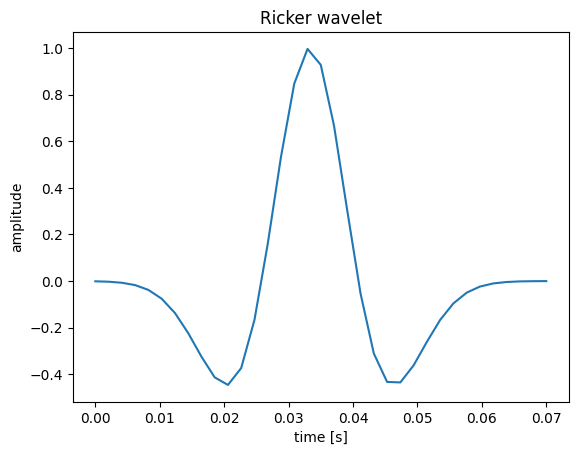

In [4]:
# Source
def ricker(t, f=10, A=1):
    '''
    f - freq in Hz
    A - amplitude
    '''
    trm = (np.pi * f * (t - 1 / f)) ** 2
    return A * (1 - 2 * trm) * np.exp(-trm)

nt1 = int(np.ceil((t1 - t0)/dt))
t = np.linspace(t0, t1, nt1)
rick = ricker(t, f=peak_freq)

fig, ax = plt.subplots(1, 1)
ax.plot(t, rick)
ax.set_title('Ricker wavelet')
ax.set_xlabel('time [s]')
ax.set_ylabel('amplitude')

print(f'The number of standard timesteps required is {nt1}')

The plot demonstrates the bulk of the wavelet is supported within the 0.07s time window. We use this to set up the source term for the initial timestepping. The operator is constructed from the stencil and source term in the usual way.

In [5]:
source = SparseTimeFunction(name="ricker", npoint=1, coordinates=[source_loc], nt=nt1, grid=grid, time_order=2, space_order=4)
source.data[:, 0] = rick
src_term = source.inject(field=u.forward, expr=source*velocity**2*dt**2)

# Regular operator to inject the source
op1 = Operator([stencil] + src_term)
op1(time=nt1 - 1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0009529999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Post execution we focus on constructing the superstep operator. This is done internally in Devito using the `superstep_generator` function, which takes as arguments:
- the existing field (`u`)
- the right hand side of the timestepping expression `stencil.rhs`
- the size of the superstep: $k$ in the paper, `superstep_size` in the code
- `nt` which is used to setup the initial state of the superstep function.

**Note:** Usually users are discouraged from restarting simulations as the final state of a Devito `TimeFunction` is not in the public API. Things are especially complicated when an alternating buffer is used. Given that resuming a simulation with a different `TimeFunction` is a common requirement of the superstep method a convenience function `superstep_solution_transfer` is supplied to populate the new time function. This is applied automatically when `superstep_generator` is called.

The function returns 4 objects:
- `new_u` and `new_u_p` two new fields used for superstepping
- stencil1 and stencil2 (`s1` and `s2` in the code) the two stencils that represent the superstep propagator

The stencils together represent the action of the propagator matrix (referred to PM) in the paper and the two fields represent the components of the vector being acted upon. Expressed symbolically:
$$
\begin{pmatrix}
u^{n+k}\\u^{n+k-1}
\end{pmatrix}
=
A^k
\begin{pmatrix}
u^n\\u^{n-1}
\end{pmatrix}
=
\begin{pmatrix}
S_1(u^n,u^{n-1})\\S_2(u^n,u^{n-1})
\end{pmatrix}
$$
The `TimeFunction`s `new_u` and `new_u_p` correspond to the functions $u^n$ and $u^{n+1}$ respectively before the application of the superstep operator and $u^{n+k}$ and $u^{n+k-1}$ after the application.

In [6]:
# Superstep operator for remainder of the simulation
new_u, new_u_p, s1, s2 = superstep_generator(u, stencil.rhs, superstep_size, nt=nt1)

As noted above the time functions `new_u` and `new_u_p` are populated with the initial condition, which is the final state of the time function `u`.

We want to snapshot the resultant simulation. We take 16 snapshots over the time range [0.07, 1.0]. We will only look at one of these for the initial simulation. We also print out the number of supersteps required to cover this time range.

In [7]:
nt2 = int(np.ceil((t2 - t1)/(dt*superstep_size)))

# Want to snapshot the solution for visualisation
nsnaps = 16
factor = int(np.ceil(nt2/nsnaps))
t_sub = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
u_save = TimeFunction(name='usave', grid=grid, time_order=0, space_order=2, save=nsnaps, time_dim=t_sub)
save = Eq(u_save, new_u)

print(f'The number of supertimesteps required is {nt2}')

The number of supertimesteps required is 93


We construct the superstepping operator corresponding to the propagator matrix in Nemeth et al. [[1]](#References). Constructing this operator is very expensive and it should be stashed, saved and reused wherever possible to avoid recomputing it!

The operator is constructed in the usual way. Notice that we have two stencils one that computes the next timestep $u(t + k\Delta t)$ and one that computes the timestep immediately preceding it $u(t + (k-1)\Delta t)$. This along with `save`, which will snapshot the simulation.

In [8]:
# Construct the operator
op2 = Operator([s1, s2, save])

In [9]:
# Execute the operator
op2(time=nt2 - 1, dt=dt)

Operator `Kernel` ran in 0.24 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.23360799999999984, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00040199999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plotting the 9th snapshot, which is closest to the state of the simulation in Figure 5 in Nemeth et al. [[1]](#References) we can see that we get the expected boundary reflection.

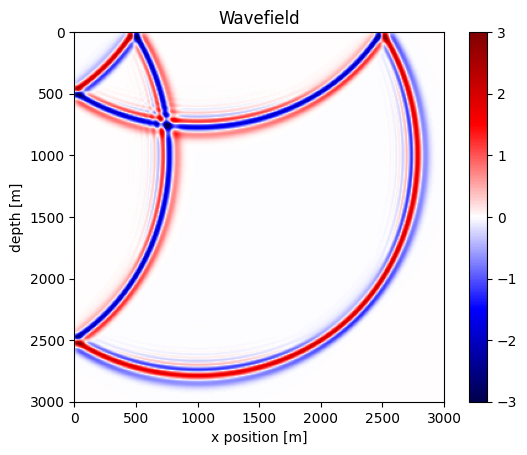

In [10]:
fig, ax = plt.subplots(1, 1)
zlim = 3

plot_extent = (origin[0], origin[0] + extent[0], origin[1] + extent[1], origin[1])
cb = ax.imshow(u_save.data[8].T, vmin=-zlim, vmax=zlim, cmap='seismic', extent=plot_extent)
ax.set_title('Wavefield')
ax.set_xlabel('x position [m]')
ax.set_ylabel('depth [m]')
_ = fig.colorbar(cb, ax=ax)

We should compare this solution to the traditional timestepping scheme, but we will reserve this for a more interesting background velocity field as we recreate figures 6 and 7 from Nemeth et al. [[1]](#References).

## Marmousi model
We start by downloading and saving the Marmousi dataset [[2]](#References) and then cropping out an interesting portion from the centre and interpolating it onto a grid the same size as the one we have been using thus far.

We also change the location of the source to the centre of the field.

In [11]:
# Grab dataset from pwd or download
from pathlib import Path
from scipy.interpolate import interpn
import urllib.request
import shutil

# Fetch and setup the Marmousi velocity field
url = 'https://github.com/devitocodes/data/raw/refs/heads/master/Simple2D/vp_marmousi_bi' # noqa: E501
filename = Path('marmousi.np')
shape = (1601, 401)
if not filename.exists():
    with urllib.request.urlopen(url) as response, open(filename, 'wb') as fh:
        shutil.copyfileobj(response, fh)
data = np.fromfile(filename, dtype=np.float32, sep='').reshape(*shape)

# We want a cropped and interpolated scection from the centre of the model
cropped = data[650:1051, 35:]
xs = np.linspace(0, 1, cropped.shape[0])
ys = np.linspace(0, 1, cropped.shape[1])
xd = np.linspace(0, 1, grid.shape[0])
yd = np.linspace(0, 1, grid.shape[1])
velocity.data[:] = 1000*interpn(
    (xs, ys), cropped, np.meshgrid(xd, yd), method='nearest'
).T

# Change the timestep to account for the larger maximum velocity in the Marmousi model
dt = 0.0015045
# Also change the shot location
source.coordinates.data[:] = np.array((1500, 1500))

Plotting the velocity field, we see that we obtain approximately the same portion of the Marmousi model. Note that we have also updated the timestep size (`dt`) to account for the higher maximum velocity in the Marmousi model.

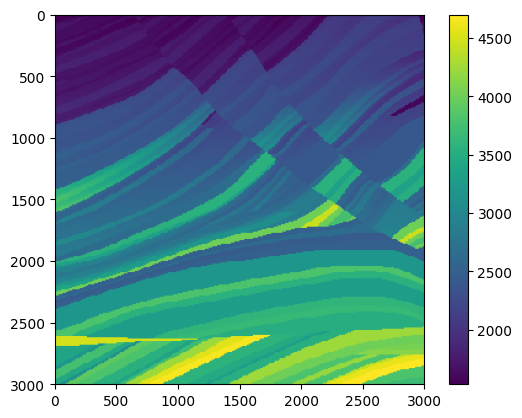

In [12]:
cb = plt.imshow(velocity.data.T, extent=plot_extent)
_ = plt.colorbar(cb)

We reset the initial `TimeFunction` and the superstepping time functions to zero so they can be reused and run the initial operator `op1` to inject the source.

In [13]:
u.data[:] = 0
new_u.data[:] = 0
new_u_p.data[:] = 0

_ = op1(time=nt1 - 1, dt=dt)

Operator `Kernel` ran in 0.01 s


We then copy the solution from `u` into `new_u` and `new_u_p`. As noted above, this is quite tricky. When initially constructing the superstep this is done automatically. However, since we are reusing the time functions we use the utility function `superstep_solution_transfer` provided by the superstepping module.

In [14]:
superstep_solution_transfer(u, new_u, new_u_p, nt1)

_ = op2(time=nt2 - 1, dt=dt)

Operator `Kernel` ran in 0.24 s


We now plot all of the snapshots to visualise the wavefield, which generates an approximate reproduction of the wavefield in figures 6 and 7 of Nemeth et al. [[1]](#References):

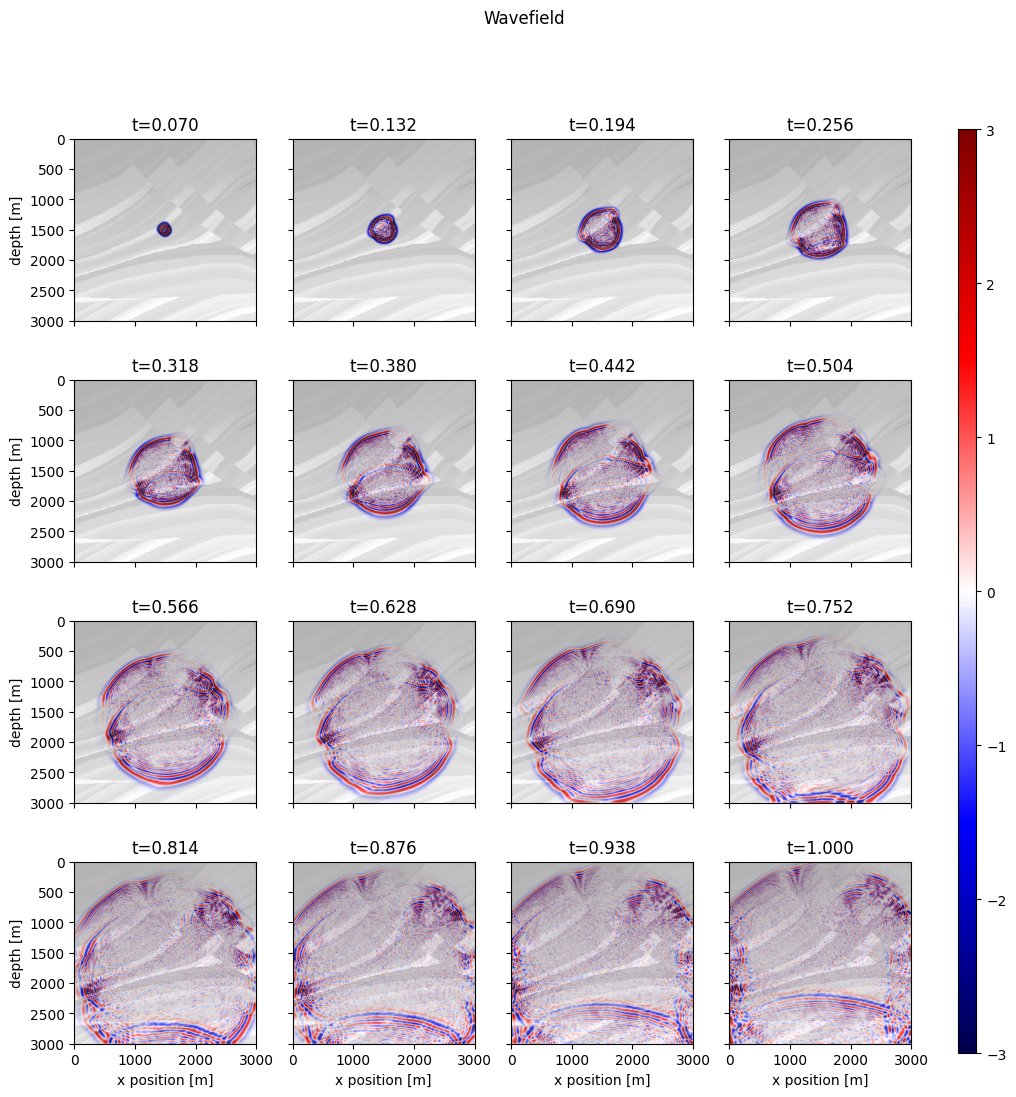

In [15]:
tlinspace = np.linspace(t1, t2, nsnaps)

fig, ax = plt.subplots(4, 4)
fig.set_size_inches(12, 12)

for ii, axis in enumerate(ax.flatten()):
    cb = axis.imshow(u_save.data[ii].T, vmin=-zlim, vmax=zlim, cmap='seismic', extent=plot_extent)
    axis.imshow(velocity.data.T, cmap='grey', extent=(0, 3000, 3000, 0), alpha=0.3)
    axis.set_title(f't={tlinspace[ii]:0.3f}')
    if ii // 4 > 2:
        axis.set_xlabel('x position [m]')
    else:
        axis.set_xticklabels([])
    if ii % 4 == 0:
        axis.set_ylabel('depth [m]')
    else:
        axis.set_yticklabels([])

fig.colorbar(cb, ax=ax, fraction=0.05, aspect=50)
_ = fig.suptitle('Wavefield')

## Verification
To check that we are getting the correct solution we compare against regular timestepping. We resume the simulation by manually copying the final state of `u` into a new time function `u_cont`. To make sure that our snapshots are commensurate with the above superstepped snapshots we take _exactly_ a factor $k$ (the superstep size) more timesteps. The operator `op3` is constructed in the usual way.

In [16]:
u_cont = TimeFunction(name="u_cont", grid=grid, time_order=2, space_order=2)
stencil2 = stencil.subs(
    {u.forward: u_cont.forward, u: u_cont, u.backward: u_cont.backward}
)
nt3 = nt2*superstep_size

# Copy the solution from u into u_cont
idx = nt1 % 3
u_cont.data[0, :] = u.data[idx - 1]
u_cont.data[1, :] = u.data[idx]

# Want to snapshot the solution for visualisation
factor = int(np.ceil(nt3/nsnaps))
t_sub = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
u_save2 = TimeFunction(name='usave2', grid=grid, time_order=0, space_order=2, save=nsnaps, time_dim=t_sub)
save2 = Eq(u_save2, u_cont)

print(f'The number of regular timesteps required is {nt3}')

The number of regular timesteps required is 465


In [17]:
op3 = Operator([stencil2, save2])

In [18]:
op3(time=nt3 - 1, dt=dt)

# For some reason the first snapshot isn't in the data
u_save2.data[0, :] = u.data[idx]

Operator `Kernel` ran in 0.02 s


We plot all the snapshots and see that they agree with what we saw above.

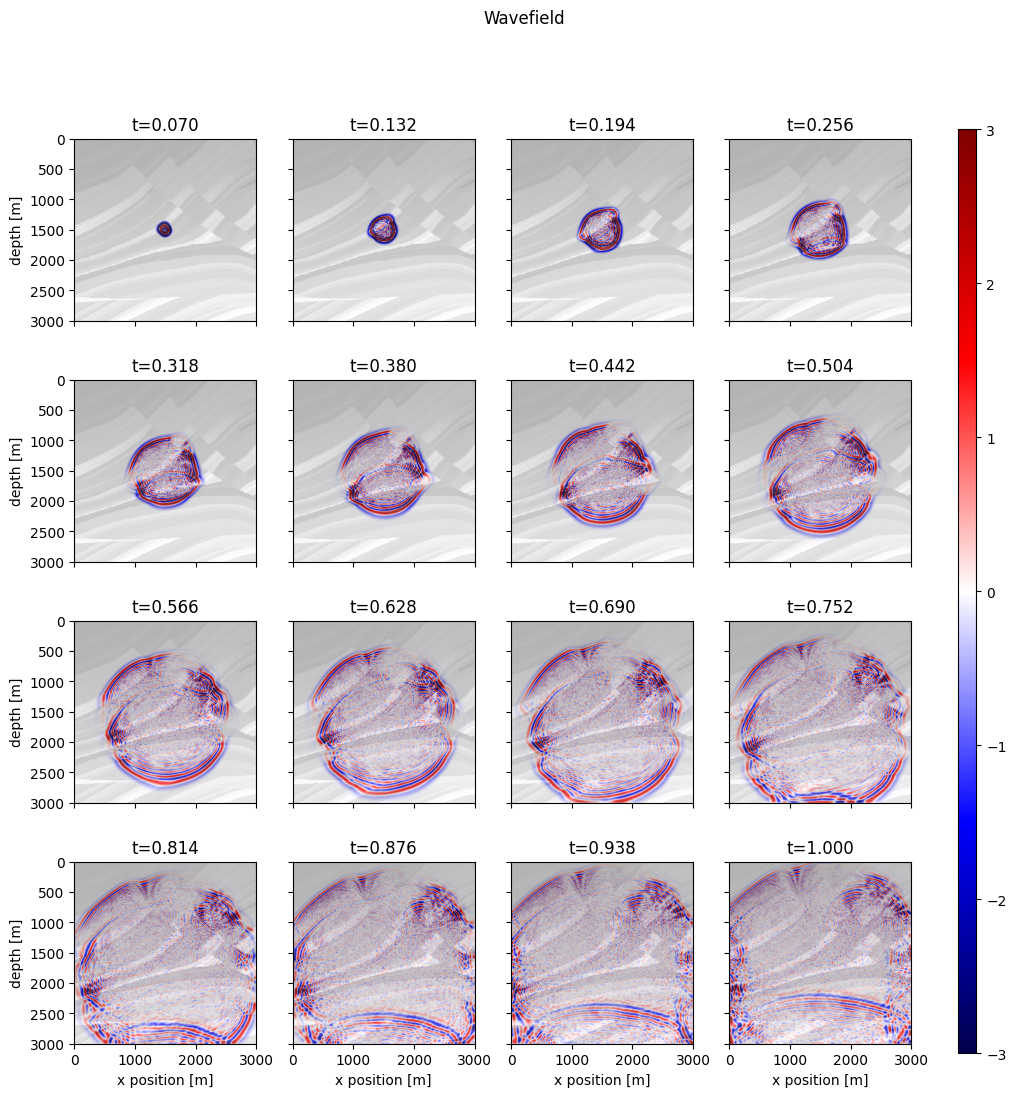

In [19]:
fig, ax = plt.subplots(4, 4)
fig.set_size_inches(12, 12)

for ii, axis in enumerate(ax.flatten()):
    cb = axis.imshow(u_save2.data[ii].T, vmin=-zlim, vmax=zlim, cmap='seismic', extent=plot_extent)
    axis.imshow(velocity.data.T, cmap='grey', extent=(0, 3000, 3000, 0), alpha=0.3)
    axis.set_title(f't={tlinspace[ii]:0.3f}')
    if ii // 4 > 2:
        axis.set_xlabel('x position [m]')
    else:
        axis.set_xticklabels([])
    if ii % 4 == 0:
        axis.set_ylabel('depth [m]')
    else:
        axis.set_yticklabels([])

fig.colorbar(cb, ax=ax, fraction=0.05, aspect=50)
_ = fig.suptitle('Wavefield')

Agreeing in the eyeball norm is satisfying, but to convince ourselves that these solutions really do agree, we plot the absolute difference between the wavefields.

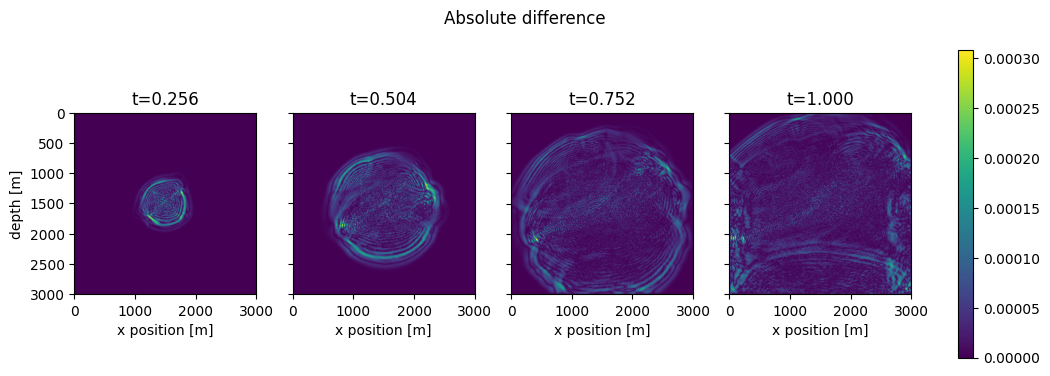

In [20]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(12, 4)

for ii, axis in enumerate(ax):
    cb = axis.imshow(np.abs(u_save.data[4*ii + 3].T - u_save2.data[4*ii + 3].T), extent=plot_extent)
    axis.set_title(f't={tlinspace[4*ii + 3]:0.3f}')
    axis.set_xlabel('x position [m]')
    if ii % 4 == 0:
        axis.set_ylabel('depth [m]')
    else:
        axis.set_yticklabels([])

fig.colorbar(cb, ax=ax, fraction=0.05)
_ = fig.suptitle('Absolute difference')

Notice that the magnitude of the error is less than $3\times 10^{-4}$ everywhere and significantly less that that over most of the domain.

## References
[1] Nemeth, T et al. (2025): Superstep wavefield propagation
<!-- @article{nemeth2025superstep,
  title={Superstep wavefield propagation},
  author={Nemeth, Tamas and Nihei, Kurt and Loddoch, Alex and Sekar, Anusha and Bube, Ken and Washbourne, John and Decker, Luke and Kaplan, Sam and Wu, Chunling and Shabelansky, Andrey and others},
  journal={Wave Motion},
  volume={134},
  pages={103489},
  year={2025},
  publisher={Elsevier}
} -->

[2] Versteeg, R.J. & Grau, G. (eds.) (1991): The Marmousi experience. Proc. EAGE workshop on Practical Aspects of Seismic Data Inversion (Copenhagen, 1990), Eur. Assoc. Explor. Geophysicists, Zeist.
<!-- @article{versteeg1994marmousi,
  title={The Marmousi experience: Velocity model determination on a synthetic complex data set},
  author={Versteeg, Roelof},
  journal={The Leading Edge},
  volume={13},
  number={9},
  pages={927--936},
  year={1994},
  publisher={Society of Exploration Geophysicists}
} -->